# Hamiltonian Simulation: Harmonic Oscillator

In [1]:
import numpy as np
from numpy import pi, sqrt, sin, cos, exp
from scipy.integrate import quad
import strawberryfields as sf
from strawberryfields.ops import *
import sys
sys.path.insert(0, './../dqs/classical')
from classical_evolution import *
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-deep')
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import warnings
warnings.filterwarnings(action='ignore', module='strawberryfields')
from tqdm import tqdm
np.random.seed(42)
sf.hbar = 1


2024-10-16 15:47:59.216693: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 15:47:59.261045: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Animation Code

In [2]:
true_classical = lambda w, m, t, x0, p0: x0 * cos(w*t) + p0/m/w*sin(w*t)

def animate_evolution(w, m, K, x0, p0, dt, xvec, snapshots1, snapshots2=None, label1='First', label2='Second', plot_classical=False, interval=20, ymax=None):
    fig, ax = plt.subplots()
    lines = []
    ln1, = ax.plot([], [], label=label1)
    if snapshots2 is not None: ln2, = ax.plot([], [], label=label2, color='k', linestyle=':')
    if plot_classical: classic, = ax.plot([], [], label='Exact Classical Solution', marker='o')
    plt.legend(loc='upper right')

    if ymax is None: max_val = .05
    else: max_val = ymax
    for snapshot in snapshots1:
        val = np.max(snapshot)
        if val > max_val:
            max_val = val
    if snapshots2 is not None:
        for snapshot in snapshots2:
            val = np.max(snapshot)
            if val > max_val:
                max_val = val

    def init():
        ax.set_xlim(-L, L)
        ax.set_ylim(-.05, max_val + .05)
        if plot_classical and snapshots2 is not None: return ln1, ln2, classic,
        if plot_classical: return ln1, classic,
        if snapshots2 is not None: return ln1, ln2,
        return ln1,

    def update(frame):
        ln1.set_data(xvec, snapshots1[frame])
        if snapshots2 is not None: ln2.set_data(xvec, snapshots2[frame])
        if plot_classical: classic.set_data([true_classical(w, m, frame*dt, x0, p0)], [0])
        if plot_classical and snapshots2 is not None: return ln1, ln2, classic,
        if plot_classical: return ln1, classic,
        if snapshots2 is not None: return ln1, ln2,
        return ln1,

    ani = FuncAnimation(fig, update, frames=list(range(K)),
                        init_func=init, blit=True, interval=interval)
    return ani


# Benchmark Hamiltonian Solution

In [3]:
def exact_hamiltonian(w, m, t, xvec, pvec, x0, p0, eng, squeeze=0, return_p_quad=False):
    prog = sf.Program(1)
    with prog.context as q:

        # Initialize state
        Vac | q[0] #initial vacuum state
        Xgate(x0) | q[0] #displace q by x0
        Zgate(p0) | q[0] #displace p by p0
        Sgate(squeeze) | q[0] #squeeze (phase angle zero)

        # Nondimensionalize the position variable
        Sgate(-np.log(sqrt(m*w))) | q[0]

        # Time step
        Rgate(-t*w) | q[0]

        # Undo nondimensionalization
        Sgate(-np.log(sqrt(m*w))).H | q[0]

    result = eng.run(prog, shots=1)
    if return_p_quad: return result.state.p_quad_values(0, xvec, pvec)
    return result.state.x_quad_values(0, xvec, pvec)


# Trotterized Hamiltonian Solution

In [4]:
def trotterized_hamiltonian(w, m, dt, xvec, pvec, K, x0, p0, eng, squeeze=0, return_p_quad=False):
    prog = sf.Program(1)
    def initial_state(p0):
        # Initialize state
        Vac | q[0] #initial vacuum state
        Xgate(x0) | q[0] #displace q by x0
        Zgate(p0) | q[0] #displace p by p0
        Sgate(squeeze) | q[0] #squeeze (phase angle zero)

    def harmonic_step_trotter(w, m, dt):
        # Time step
        Fouriergate() | q[0]
        Pgate(-dt/m) | q[0]
        Fouriergate().H | q[0]
        Pgate(-m*w**2*dt) | q[0]

    with prog.context as q:
        initial_state(p0)
        for _ in range(K):
            harmonic_step_trotter(w, m, dt)

    result = eng.run(prog, shots=1)
    if return_p_quad: return result.state.p_quad_values(0, xvec, pvec)
    return result.state.x_quad_values(0, xvec, pvec)


# Benchmark Liouvillian Solution

In [5]:
def exact_liouvillian(w, m, t, xvec, pvec, x0, p0, squeeze=0, return_p_quad=False):
    def integrand(q, p):
        q_new = lambda q, p: (q*cos(w*t) - p/w*sin(w*t))#/exp(-squeeze)
        p_new = lambda q, p: (w*q*sin(w*t) + p*cos(w*t))/exp(squeeze)
        rho = exp(-(q_new(q, p) - x0)**2 - (p_new(q, p) - p0)**2)/pi
        return rho*exp(-squeeze)
    marginals = []
    err = []
    if return_p_quad:
        for p in pvec:
            res = quad(lambda x: integrand(x, p), -np.inf, np.inf, epsabs=1.49e-10)
            marginals.append(res[0])
            err.append(res[1])
        return np.array(marginals), err

    for x in xvec:
        res = quad(lambda p: integrand(x, p), -np.inf, np.inf, epsabs=1.49e-10)
        marginals.append(res[0])
        err.append(res[1])
    return np.array(marginals), err


# Trotterized Liouvillian Solution

In [6]:
def trotterized_liouvillian(w, m, dt, xvec, xpvec, pvec, ppvec, K, x0, p0, eng, squeeze=0, return_p_quad=False):
    prog = sf.Program(2)
    with prog.context as q:
        def initial_state(x0, p0):
            # Initialize state
            Vac | q[0] #initial vacuum state
            Vac | q[1] #initial vacuum state
            Xgate(x0) | q[0] #displace q by x0
            Xgate(p0) | q[1] #displace p by p0
            # Sgate(squeeze) | q[0] #squeeze (phase angle zero)
            Sgate(squeeze).H | q[1] #squeeze (phase angle zero)


        def step(w, dt):
            # Time step
            CXgate(-dt*m*w**2) | (q[0], q[1])
            CXgate(dt/m) | (q[1], q[0])

        initial_state(x0, p0)
        for _ in range(K):
            step(w, dt)

    result = eng.run(prog, shots=1)
    if return_p_quad: return result.state.x_quad_values(1, pvec, ppvec)
    return result.state.x_quad_values(0, xvec, xpvec)


# Check Initial States

In [7]:
w = .9
m = 1
x0 = 1
p0 = 0
squeeze = .5
K = 200
dt = 1/w/K*2*pi #go for 2 full periods
L = 6
xvec, pvec = np.linspace(-L, L, 500), 10*np.linspace(-L, L, 500)
xpvec, ppvec = pvec, 10*pvec

ham_init_x_1 = exact_hamiltonian(w, m, 0, xvec, pvec, x0, p0, sf.Engine('gaussian'), squeeze=squeeze)
ham_init_p_1 = exact_hamiltonian(w, m, 0, xvec, pvec, x0, p0, sf.Engine('gaussian'), squeeze=squeeze, return_p_quad=True)
ham_init_x_2 = trotterized_hamiltonian(w, m, dt, xvec, pvec, 0, x0, p0, sf.Engine('gaussian'), squeeze=squeeze)
ham_init_p_2 = trotterized_hamiltonian(w, m, dt, xvec, pvec, 0, x0, p0, sf.Engine('gaussian'), squeeze=squeeze, return_p_quad=True)
liou_init_x_1 = exact_liouvillian(w, m, 0, xvec, pvec, x0, p0, squeeze=squeeze)[0]
liou_init_p_1 = exact_liouvillian(w, m, 0, xvec, pvec, x0, p0, squeeze=squeeze, return_p_quad=True)[0]
liou_init_x_2 = trotterized_liouvillian(w, m, 0, xvec, xpvec, pvec, ppvec, 0, x0, p0, sf.Engine('gaussian'), squeeze=squeeze)
liou_init_p_2 = trotterized_liouvillian(w, m, 0, xvec, xpvec, pvec, xpvec, 0, x0, p0, sf.Engine('gaussian'), squeeze=squeeze, return_p_quad=True)


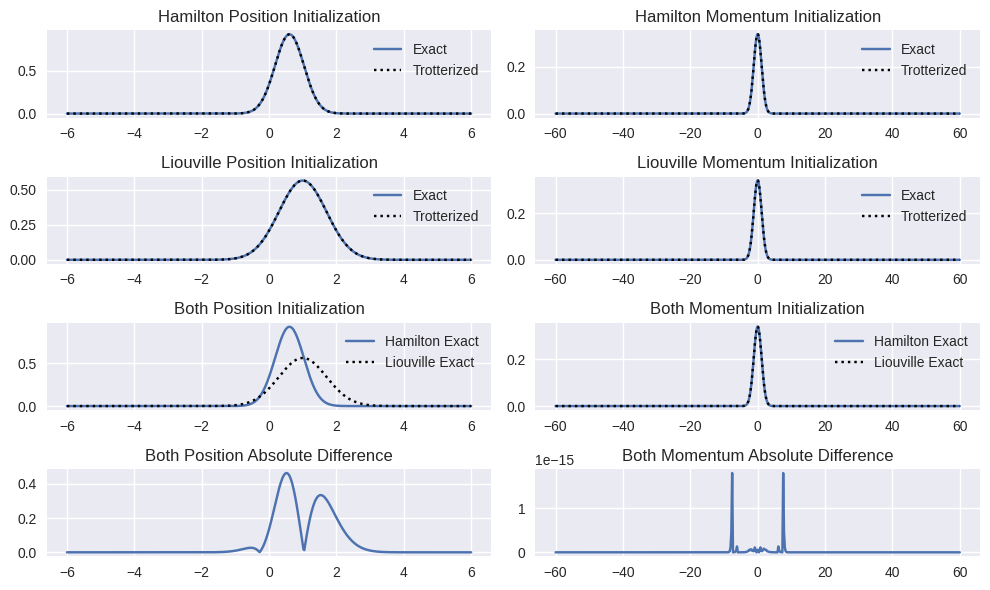

In [8]:
fig, axes = plt.subplots(4, 2, figsize=(10, 6))
ax = axes.ravel()

ax[0].plot(xvec, ham_init_x_1, label='Exact')
ax[0].plot(xvec, ham_init_x_2, ':k', label='Trotterized')
ax[0].set_title(r'Hamilton Position Initialization')
ax[0].legend()

ax[1].plot(pvec, ham_init_p_1, label='Exact')
ax[1].plot(pvec, ham_init_p_2, ':k', label='Trotterized')
ax[1].set_title(r'Hamilton Momentum Initialization')
ax[1].legend()

ax[2].plot(xvec, liou_init_x_1, label='Exact')
ax[2].plot(xvec, liou_init_x_2, ':k', label='Trotterized')
ax[2].set_title(r'Liouville Position Initialization')
ax[2].legend()

ax[3].plot(pvec, liou_init_p_1, label='Exact')
ax[3].plot(pvec, liou_init_p_2, ':k', label='Trotterized')
ax[3].set_title(r'Liouville Momentum Initialization')
ax[3].legend()

ax[4].plot(xvec, ham_init_x_1, label='Hamilton Exact')
ax[4].plot(xvec, liou_init_x_1, ':k', label='Liouville Exact')
ax[4].set_title(r'Both Position Initialization')
ax[4].legend()

ax[5].plot(pvec, ham_init_p_1, label='Hamilton Exact')
ax[5].plot(pvec, liou_init_p_1, ':k', label='Liouville Exact')
ax[5].set_title(r'Both Momentum Initialization')
ax[5].legend()

ax[6].plot(xvec, np.abs(ham_init_x_1 - liou_init_x_1), label='Hamilton Exact')
ax[6].set_title(r'Both Position Absolute Difference')

ax[7].plot(pvec, np.abs(ham_init_p_1 - liou_init_p_1), label='Hamilton Exact')
ax[7].set_title(r'Both Momentum Absolute Difference')

plt.tight_layout()
plt.show()


# Time Evolution Animations

In [9]:
# w = 3
m = 1
x0 = 1
p0 = 0
# squeeze = 2
# K = 100
dt = 1/w/K*2*pi #go for 2 full periods
# L = 7
xvec, pvec = np.linspace(-L, L, 500), 10*np.linspace(-L, L, 500)
xpvec, xpvec = pvec.copy(), 10*pvec.copy()
tvec = np.arange(0, dt*K, dt)


In [10]:
exact_ham_snapshots = []
trotter_ham_snapshots = []
progress = tqdm(total=2*K)
for k in range(K):
    result1 = exact_hamiltonian(w, m, dt*k, xvec, pvec, x0, p0, sf.Engine('gaussian'), squeeze=squeeze)
    exact_ham_snapshots.append(result1)
    progress.update(1)

    result2 = trotterized_hamiltonian(w, m, dt, xvec, pvec, k, x0, p0, sf.Engine('gaussian'), squeeze=squeeze)
    trotter_ham_snapshots.append(result2)
    progress.update(1)

progress.close()


100%|██████████| 400/400 [00:34<00:00, 11.61it/s]


In [11]:
sum(trotter_ham_snapshots[25])*(xvec[1] - xvec[0]), sum(exact_ham_snapshots[25][:-1])*(xvec[1] - xvec[0])


(0.999999996020887, 0.9999999958249306)

In [12]:
max_val = .05
for snapshot_list in trotter_ham_snapshots:
        for snapshot in snapshot_list:
            val = np.max(snapshot)
            if val > max_val:
                max_val = val

In [13]:
anim = animate_evolution(w, m, K, x0, p0, dt, xvec,
    snapshots2=exact_ham_snapshots,
    snapshots1=trotter_ham_snapshots,
    label2='Exact Hamiltonian',
    label1='Trotterized Hamiltonian',
    plot_classical=False, interval=30, ymax=max_val)
anim.save('./animations/hamiltonian.gif', writer='ffmpeg')
video = HTML(anim.to_html5_video())
display(video)
plt.close()


In [14]:
exact_liou_snapshots = []
trotter_liou_snapshots = []
quad_errors = []
progress = tqdm(total=2*K)
for k in range(K):
    result3, err = exact_liouvillian(w, m, dt*k, xvec, pvec, x0, p0, squeeze=squeeze)
    exact_liou_snapshots.append(result3)
    quad_errors.append(err)
    progress.update(1)

    result4 = trotterized_liouvillian(w, m, dt, xvec, xpvec, pvec, ppvec, k, x0, p0, sf.Engine('gaussian'), squeeze=squeeze)
    trotter_liou_snapshots.append(result4)
    progress.update(1)

progress.close()


  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [03:19<00:00,  2.01it/s]


In [15]:
sum(trotter_liou_snapshots[-1])*(xvec[1] - xvec[0]), sum(exact_liou_snapshots[-1][:-1])*(xvec[1] - xvec[0])


(0.6382100764984865, 0.9999999999990608)

In [16]:
anim2 = animate_evolution(w, m, K, x0, p0, dt, xvec,
    snapshots2=exact_liou_snapshots,
    snapshots1=trotter_liou_snapshots,
    label2='Exact Liouvillian',
    label1='Trotterized Liouvillian',
    plot_classical=False, interval=30, ymax=max_val)
anim2.save('./animations/liouvillian.gif', writer='ffmpeg')
video2 = HTML(anim2.to_html5_video())
display(video2)
plt.close()


In [17]:
# anim2 = animate_evolution(w, m, K, x0, p0, dt, xvec,
#     snapshots2=exact_liou_snapshots,
#     snapshots1=exact_ham_snapshots,
#     label2='Exact Liouvillian',
#     label1='Exact Hamiltonian',
#     plot_classical=False, interval=25)
# # anim2.save('./animations/liouvillian_vs_hamiltonian.gif', writer='ffmpeg')
# video2 = HTML(anim2.to_html5_video())
# display(video2)
# plt.close()


# Error Plots

In [18]:
# errors = [np.linalg.norm(exact_ham_snapshots[i] - trotter_ham_snapshots[i])/np.linalg.norm(exact_ham_snapshots[i]) for i in range(K)]
# plt.plot(np.arange(0, dt*K, dt), errors)
# plt.xlabel('t')
# plt.ylabel('relative error')
# plt.title('Hamiltonian Trotterization Error')
# plt.show()


In [19]:
# errors = [np.linalg.norm(exact_liou_snapshots[i] - trotter_liou_snapshots[i])/np.linalg.norm(exact_liou_snapshots[i]) for i in range(K)]
# plt.plot(np.arange(0, dt*K, dt), errors)
# plt.xlabel('t')
# plt.ylabel('relative error')
# plt.title('Liouville Trotterization Error')
# plt.show()


In [20]:
# errors = [np.linalg.norm(exact_ham_snapshots[i] - exact_liou_snapshots[i]) for i in range(K)]
# plt.plot(tvec, errors)
# plt.plot(tvec[[0, -1]], [1.49e-10 for i in range(2)])
# plt.xlabel('t')
# plt.title(r'$\Vert$ liouville - trotter $\Vert$')
# plt.ylim(-5e-10, 5e-9)
# plt.show()


In [21]:
anim = animate_evolution(w, m, K, x0, p0, dt, xvec,
    snapshots1=exact_ham_snapshots,
    label1='',
    plot_classical=False, interval=30, ymax=max_val)
anim.save('./animations/new.gif', writer='ffmpeg')
video = HTML(anim.to_html5_video())
display(video)
plt.close()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
